<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Don't remount unless necessary

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! 

In [19]:
ls

problems.txt  TheGreatestTest.ipynb


In [23]:
f = open('problems.txt', 'r')
print(f.read())
f.close()

perpetual problems have no perceived solutions


In [0]:
import numpy as N
import  pylab
import scipy.optimize as optimize
 
 
def bsol(temp,p):
    Tn,Jt,Nf,Bk=p
    t=4.0*(Jt/(Jt+1.0))*Tn/temp
    #print t
    if (Tn<=0) or (Jt<=0) or temp>=Tn:
        xout=0.0
    else:
        xout=optimize.brentq(bfun,0.0,t,args=(temp,p),xtol=1e-6)
 
    return xout
 
def bfun(x,T,p):
    Tn,Jt,Nf,Bk=p
    if x==0.0:
        B=-1.0#   /* so that it wont find solution at zero */
    else:
        B=(x-3*brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
    return B
 
def brill(j,x):
    temp=(2*j+1.0)/2/j
    if x==0:
        Br=0.0
    else:
        Br=temp/N.tanh(temp*x)-1.0/N.tanh(x/2/j)/2/j
    return Br
 
def Intensity(T,p):
    Tn,Jt,Nf,Bk=p
    br=brill(Jt,bsol(T,p))
    bout=Bk+Nf*br**2
    return bout
 
def orderparameter(p,T):
    I=[]
    for t in T:
        I.append(Intensity(t,p))
    return N.array(I)

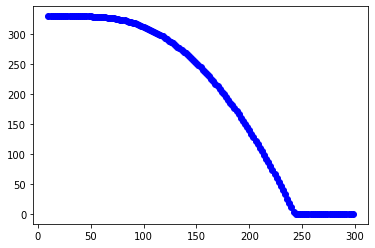

In [3]:
if __name__=='__main__':
 
    p=[50.0,0.5,100.0,0.0]
    p=[243,.885,330,.3 ]
    T=N.arange(300.0)
    T=N.arange(10,300,2)
    I=[]
    M=[]
 
    I=orderparameter(p,T)
 
    if 1:
        pylab.plot(T,I,'bo')
        pylab.show()